The goal of this analysis is to identify different customer segments based on their purchasing behavior, allowing the business to tailor its marketing strategies and improve customer retention and sales.

**Steps to Perform RFM Analysis**
* Load and Prepare the Data
* Calculate RFM Metrics
* Assign RFM Scores
* Segment Customers Based on RFM Scores
* Interpret the Results

# Load the df

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel(r"D:\Portfolio Github\customer_purchase_behavior\online_retail_II.xlsx", sheet_name = "Year 2009-2010" )
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Getting to know the variables:¶
* **InvoiceNo** : The number of the invoice, unique per each purchase. Refund invoice numbers contain "C"
* **StockCode** : Unique code per each item
* **Description** : Name of the item
* **Quantity** : The number of items within the invoice
* **InvoiceDate** : Date and time of the purchase
* **UnitPrice** : Price of a single item, as of Sterlin
* **CustomerID** : Unique id number per each customer
* **Country** : The country where the customer is living

In [3]:
df.shape

(525461, 8)

In [4]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

# Data Quality and Preparation:

* ### Are there any patterns in missing or inconsistent df that we should be aware of (e.g., missing customer IDs, negative quantities)?

In [5]:
# Check for rows with missing Customer ID
missing_customer_id = df[df['Customer ID'].isnull()]

#Check for rows with negative quantities
negative_quantities = df[df['Quantity'] < 0]

# Output the results
print("\nRows with Missing Customer ID:\n", missing_customer_id.shape)
print("\nRows with Negative Quantities:\n", negative_quantities.shape)


Rows with Missing Customer ID:
 (107927, 8)

Rows with Negative Quantities:
 (12326, 8)


In [6]:
# Separate rows with negative quantities
returns_data = df[df['Quantity'] < 0]
sales_data = df[df['Quantity'] >= 0]

# Check the results
print(f"Sales data shape (positive quantities): {sales_data.shape}")
print(f"Returns data shape (negative quantities): {returns_data.shape}")


Sales data shape (positive quantities): (513135, 8)
Returns data shape (negative quantities): (12326, 8)


In [7]:
# Create a new column 'Transaction Type' to indicate 'Return' or 'Sale'
df['Transaction Type'] = df['Quantity'].apply(lambda x: 'Return' if x < 0 else 'Sale')

# Convert all quantities to positive values
df['Quantity'] = df['Quantity'].abs()

In [8]:
# Handle missing values
# Drop rows with missing Customer ID since it's crucial for RFM analysis
df = df.dropna(subset=['Customer ID'])

# Fill missing values in other columns with appropriate methods (if necessary)
# For example, filling missing Description with 'Unknown'
df['Description'].fillna('Unknown', inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417534 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Invoice           417534 non-null  object        
 1   StockCode         417534 non-null  object        
 2   Description       417534 non-null  object        
 3   Quantity          417534 non-null  int64         
 4   InvoiceDate       417534 non-null  datetime64[ns]
 5   Price             417534 non-null  float64       
 6   Customer ID       417534 non-null  float64       
 7   Country           417534 non-null  object        
 8   Transaction Type  417534 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 31.9+ MB


In [10]:
# Convert Customer ID from float to string
df['Customer ID'] = df['Customer ID'].astype(str)

------------------------------

* ### Are there outliers (e.g., extremely high or low purchase amounts) that might skew the analysis?
    - Yes, there are 34,957 outliers in the dataset with extremely high or low purchase amounts, which could potentially skew the analysis.

In [11]:
# Calculate the total purchase amount for each row
df['Total Amount'] = df['Quantity'] * df['Price']

In [12]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['Total Amount'].quantile(0.25)
Q3 = df['Total Amount'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [13]:
# Identify outliers
outliers = df[(df['Total Amount'] < lower_bound) | (df['Total Amount'] > upper_bound)]

# Check the result
print(f"Number of outliers: {outliers.shape[0]}")
print("Outliers in the data:\n", outliers[['Invoice', 'Quantity', 'Price', 'Total Amount']].head())

Number of outliers: 34957
Outliers in the data:
   Invoice  Quantity  Price  Total Amount
0  489434        12   6.95          83.4
1  489434        12   6.75          81.0
2  489434        12   6.75          81.0
3  489434        48   2.10         100.8
7  489434        10   5.95          59.5


---------------------------

* ### How does the data distribution look for key metrics like total sales, number of transactions?

In [15]:
# Calculate Number of Transactions
number_of_transactions = df['Invoice'].nunique()

In [16]:
# Calculate Recency of Purchases
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
latest_purchase_date = df['InvoiceDate'].max()
df['Recency'] = (latest_purchase_date - df['InvoiceDate']).dt.days

In [18]:
# Aggregate Total Sales by Customer
total_sales_by_customer = df.groupby('Customer ID')['Total Amount'].sum()

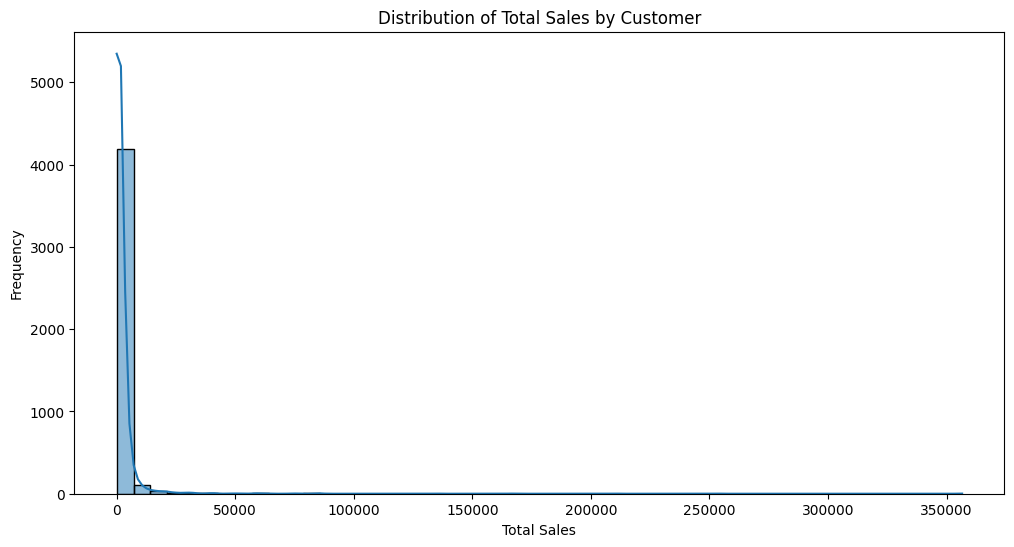

In [19]:
# Plot Total Sales Distribution
plt.figure(figsize=(12, 6))
sns.histplot(total_sales_by_customer, bins=50, kde=True)
plt.title('Distribution of Total Sales by Customer')
plt.xlabel('Total Sales')
plt.ylabel('Frequency')
plt.show()

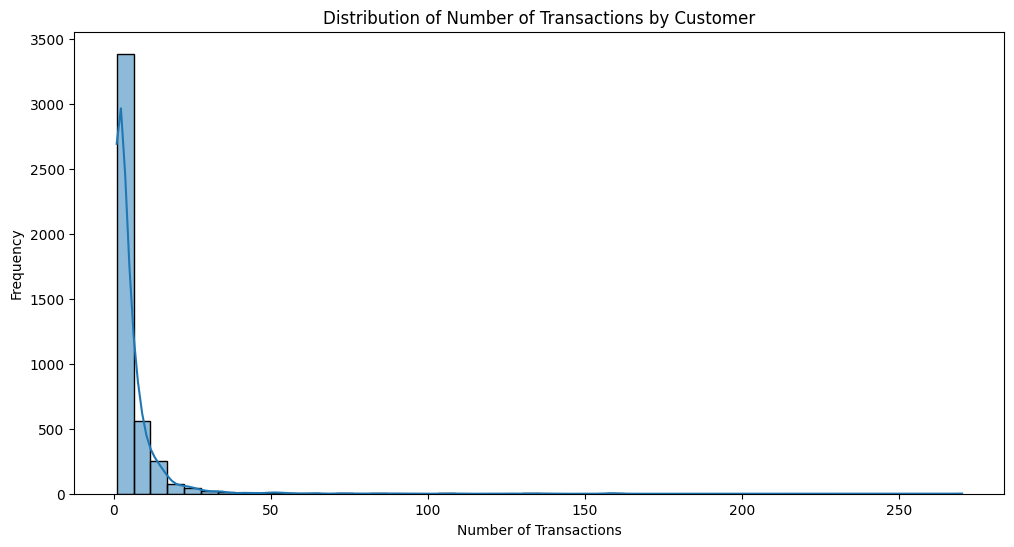

In [21]:
# Plot Number of Transactions Distribution
transaction_counts_by_customer = df.groupby('Customer ID')['Invoice'].nunique()
plt.figure(figsize=(12, 6))
sns.histplot(transaction_counts_by_customer, bins=50, kde=True)
plt.title('Distribution of Number of Transactions by Customer')
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')
plt.show()

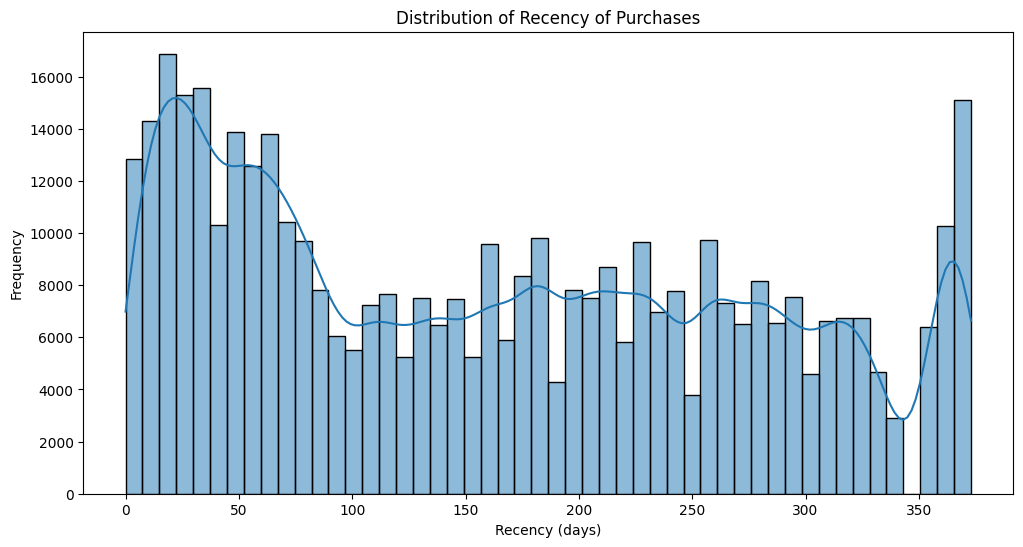

In [22]:
# Plot Recency Distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['Recency'], bins=50, kde=True)
plt.title('Distribution of Recency of Purchases')
plt.xlabel('Recency (days)')
plt.ylabel('Frequency')
plt.show()

* ### How many unique customers are there in the dataset, and what percentage of them have made recent purchases?

----------------------------------
---------------------------------------

# Customer Segmentation:

* ### Can we identify the top 10% of customers based on their RFM scores? What characteristics do these customers share?

1. Data Quality and Preparation:
Are there any patterns in missing or inconsistent data that we should be aware of (e.g., missing customer IDs, negative quantities)?
How does the data distribution look for key metrics like total sales, number of transactions, and recency of purchases?
Are there outliers (e.g., extremely high or low purchase amounts) that might skew the analysis?
2. 
How many unique customers are there in the dataset, and what percentage of them have made recent purchases?
Can we identify the top 10% of customers based on their RFM scores? What characteristics do these customers share?
Are there any significant differences in RFM scores across different regions or customer demographics (if available)?
3. Recency Analysis:
What is the average time since the last purchase for our customers?
How do recent buyers (e.g., those who purchased within the last 30 days) differ from older buyers in terms of frequency and monetary value?
Are there seasonal trends in customer purchases, and how does this affect recency scores?
4. Frequency Analysis:
What is the distribution of purchase frequency across customers (e.g., one-time buyers vs. repeat buyers)?
Which customer segments have the highest repeat purchase rates, and what products are they buying most often?
How does frequency correlate with recency and monetary value? Are frequent buyers also recent buyers?
5. Monetary Value Analysis:
What is the average monetary value of a transaction, and how does it vary by customer segment?
Which customers contribute the most to our total revenue, and are they also the most frequent buyers?
Are there specific products or categories driving higher monetary values among top customers?
6. Customer Retention and Loyalty:
How does the distribution of RFM scores relate to customer retention? Are we retaining high RFM score customers?
What percentage of customers fall into the "best customer" segment (e.g., high RFM scores)?
Are there specific actions we can take to increase retention among low-recency customers?
7. Business Impact:
How does the customer lifetime value (CLTV) compare across different RFM segments?
What marketing strategies can be developed to target customers with different RFM profiles?
Can we estimate the potential revenue uplift by focusing marketing efforts on high-RFM score segments?
8. Recommendations:
Based on the RFM analysis, what customer segments should we prioritize for upcoming marketing campaigns?
Are there any specific cross-sell or upsell opportunities identified from the RFM analysis?
What other data points should we consider integrating with RFM to enhance the segmentation and analysis (e.g., customer demographics, product preferences)?